## 1. Loading packages

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pickle
import swifter
import cv2
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
tf.__version__
import warnings
warnings.filterwarnings("ignore")

## 2. Loading data

In [2]:
DATASET_PATH = "data"
print(os.listdir(DATASET_PATH))

['images', 'myntradataset', 'styles.csv']


In [3]:
data = pd.read_csv(DATASET_PATH + "/styles.csv",  error_bad_lines=False)
data['image'] = data.apply(lambda row: str(row['id']) + ".jpg", axis=1)
data = data.reset_index(drop=True)
data.head(10)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,30039.jpg


In [4]:
_, _, files = next(os.walk(DATASET_PATH+'/images'))
file_count = len(files)
print("Number of images:", file_count)

Number of images: 44441


In [5]:
print("Number of images having the info:", data.shape[0])
print("Number of images:", file_count)

Number of images having the info: 44424
Number of images: 44441


#### Comment : We can see that there are some discrepancies in the data. Let's take the intersection of the number of photos and the photo info. 

## 3. Pre-processing data 

In [6]:
#findind common photos ids
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

image_id= intersection(data['image'], files)

In [7]:
#Keeping only common photo ids in the data
for i, row in data.iterrows():
    if row['image'] not in image_id:
        data.drop(i, inplace=True)

In [8]:
data.shape

(44419, 11)

In [9]:
#function to load images
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img):
    return cv2.imread(img_path(img))

## 4. Visualization

### 4.1 Displaying count for article types 

In [10]:
subCategory_sum = data.groupby(['articleType'], sort=True).size().reset_index(name='Count')
print("Total image categories:", len(subCategory_sum))
subCategory_sum.sort_values(by = 'Count', ascending=False)

Total image categories: 142


,articleType,Count
133,Tshirts,7066
104,Shirts,3215
19,Casual Shoes,2845
139,Watches,2542
112,Sports Shoes,2036
...,...,...
54,Ipad,1
46,Hair Accessory,1
79,Mens Grooming Kit,1
26,Cushion Covers,1


In [11]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    


### 4.2 Plotting sample figures in the dataset

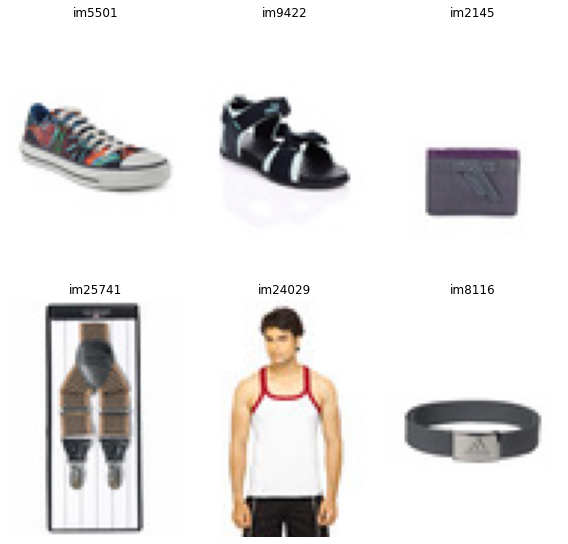

In [12]:
import matplotlib.pyplot as plt
import numpy as np

figures = {'im'+str(i): load_image(row.image) for i, row in data.sample(6).iterrows()}
plot_figures(figures, 2, 3)

### 4.3 Gender vs Master Category

<AxesSubplot:xlabel='gender'>

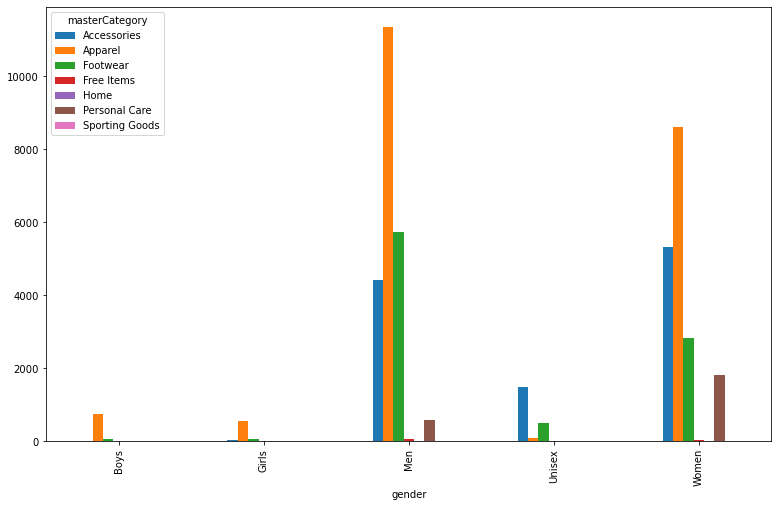

In [13]:
group=data.groupby([data['gender'], data["masterCategory"]]).size()
group_pd=group.unstack(level=1)
group_pd.plot(kind='bar', figsize=(13,8))

#plt.legend(["Entire home/apt","Private room", "Shared room"])

### 4.4 Number of products released every year

Text(0, 0.5, 'Number of products')

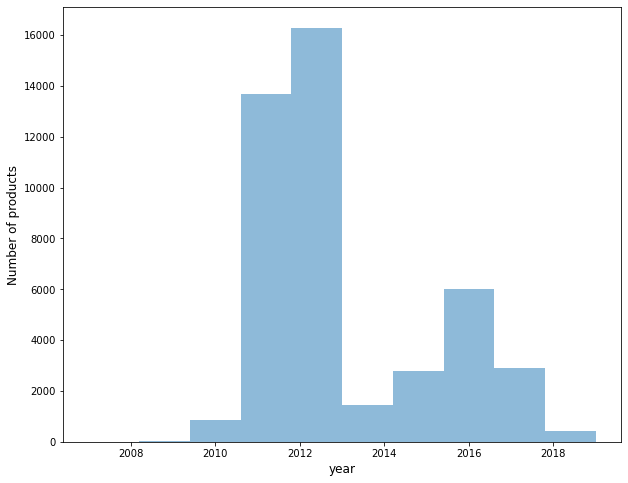

In [14]:
plt.figure(figsize=(10,8))
data['year'].plot.hist(alpha=0.5)
plt.xlabel('year', fontsize=12)
plt.ylabel("Number of products", fontsize=12)

### 4.5 Top 20 Article Types based on their count

<AxesSubplot:>

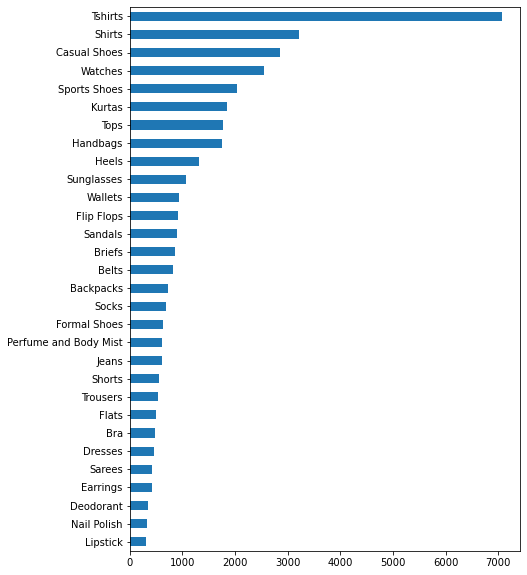

In [15]:
plt.figure(figsize=(7,10))
data.articleType.value_counts().sort_values()[-30:].plot(kind='barh')

## 5. Deep Learning Models for feature extraction (Embeddings)

In [16]:
#Models to try

def inceptionModel(height, width):
    model = InceptionV3(weights='imagenet', include_top=False, input_shape = (height, width, 3))
    model.trainable = False
    output = GlobalMaxPooling2D()(model.outputs)
    model = Model(inputs=model.inputs, outputs=output)
    #model.summary()
    return model
    
def mobileNet(height, width):
    model = MobileNet(weights='imagenet', include_top=False, input_shape = (height, width, 3))
    model.trainable = False
    output = GlobalMaxPooling2D()(model.outputs)
    model = Model(inputs=model.inputs, outputs=output)
    model.summary()
    return model

def resNet(height, width):
    model = ResNet50(weights='imagenet', include_top=False, input_shape = (height, width, 3))
    model.trainable = False
    output = GlobalMaxPooling2D()(model.outputs)
    model = Model(inputs=model.inputs, outputs=output)
    model.summary()
    return model

def vgg(height, width):
    model = VGG16(weights='imagenet', include_top=False, input_shape = (height, width, 3))
    model.trainable = False
    output = GlobalMaxPooling2D()(model.outputs)
    model = Model(inputs=model.inputs, outputs=output)
    model.summary()
    return model

In [17]:
#pipeline to load the image and make embedding out of it
# Reference from Kaggle notebook: https://www.kaggle.com/code/mrmaheshchavan/feature-extraction-pca-clustering

def get_embedding(model, img_name, height, width):
    img = image.load_img(img_path(img_name), target_size=(height, width))
    x   = image.img_to_array(img)
    x   = np.expand_dims(x, axis=0)
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [18]:
height, width, _ =load_image(data.iloc[1].image).shape
model=resNet(height, width)
emb = get_embedding(model, data.iloc[1].image,height, width)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 86, 66, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 40, 30, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 40, 30, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [19]:
emb.shape

(4096,)

## 6. Getting the embedding matrix using swifter (The following code was computed on Kaggle GPU)

In [ ]:
# Parallel apply
model=resNet(height, width)
mapping_embeddings = data['image'].swifter.apply(lambda image: get_embedding(model, image, height, width))
df_embs_resnet        = mapping_embeddings.apply(pd.Series)

print(df_embs_resnet.shape)
df_embs_resnet.head()

In [ ]:
model=vgg(height, weight)
map_embeddings = data['image'].swifter.apply(lambda img: get_embedding(model, img))
df_embs_vgg        = map_embeddings.apply(pd.Series)

print(df_embs_vgg.shape)
df_embs_vgg.head()

In [ ]:
model= mobileNet(height, weight)
map_embeddings = data['image'].swifter.apply(lambda img: get_embedding(model, img))
df_embs_mobile    = map_embeddings.apply(pd.Series)

print(df_embs_mobile.shape)
df_embs_mobile.head()

In [ ]:
import pickle
pickle.dump( df_embs_resnet, open( "./embeddings.csv", "wb" ) )

In [ ]:
import pickle
pickle.dump( df_embs_vgg, open( "./embeddings_vgg.pkl", "wb" ) )

In [ ]:
import pickle
pickle.dump( df_embs_mbile, open( "./embeddings_mobile.pkl", "wb" ) )

## 7. Loading the Embeddings in local for all 3 models and Computing cosine similarity 

In [20]:
import pandas as pd
import pickle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np 
import pandas as pd 
import os 
import cv2

In [21]:
df_embs_resnet = pickle.load( open( "embeddings.csv", "rb" ) )
df_embs_vgg = pickle.load( open( "embeddings_vgg.pkl", "rb" ) )
df_embs_mobile = pickle.load( open( "embeddings_mobile.pkl", "rb" ) )

In [22]:
df_embs_resnet=df_embs_resnet.reset_index(drop=True)
df_embs_vgg=df_embs_vgg.reset_index(drop=True)
df_embs_mobile=df_embs_mobile.reset_index(drop=True)

In [23]:
df_embs_resnet= df_embs_resnet.sample(frac=0.5)
idx_train= df_embs_resnet.index

In [24]:
df_embs_vgg = df_embs_vgg.iloc[idx_train]
df_embs_mobile = df_embs_mobile.iloc[idx_train]

In [49]:
test_size= int(len(df_embs_resnet)*0.1)

### Cosine Similarity

In [25]:
from sklearn.metrics.pairwise import pairwise_distances
# Calcule DIstance Matriz
cosine_sim_resnet = 1-pairwise_distances(df_embs_resnet, metric='cosine')

In [26]:
cosine_sim_vgg = 1-pairwise_distances(df_embs_vgg, metric='cosine')

In [27]:
cosine_sim_mobile = 1-pairwise_distances(df_embs_mobile, metric='cosine')

In [54]:
resnet_test_cos= cosine_sim_resnet[test_size:]
vgg_test_cos= cosine_sim_vgg[test_size:]
mobile_test_cos= cosine_sim_mobile[test_size:]

## 8. Evaluation of models

### 8.1 Intra-list similarity

In [51]:
print('Resnet', np.average(resnet_test_cos))

Resnet 0.33054045


In [52]:
print('VGG', np.average(vgg_test_cos))

VGG 0.2871167


In [55]:
print('Mobile', np.average(mobile_test_cos))

Mobile 0.3036144


#### We can see that Intra list similarity for resnet is highest 

### 8.2 Prediction Coverage

In [58]:
## Random test set
df_resnet_coverage = df_embs_resnet.copy()

In [59]:
df_resnet_coverage=df_resnet_coverage.reset_index()
df_resnet_coverage_test= df_resnet_coverage[test_size:]

In [60]:
import recmetrics

In [70]:
catalog = df_resnet_coverage_test.index
resnet_coverage = recmetrics.catalog_coverage(vgg_test_cos, catalog, 100)

In [71]:
resnet_coverage

9505.63

In [72]:
df_vgg_coverage = df_embs_vgg.copy()
df_vgg_coverage=df_vgg_coverage.reset_index()
df_vgg_coverage_test= df_vgg_coverage[test_size:]

In [73]:
vgg_coverage = recmetrics.catalog_coverage(resnet_test_cos, catalog, 100)

In [74]:
vgg_coverage

9125.87

In [66]:
df_mobile_coverage = df_embs_mobile.copy()
df_mobile_coverage=df_mobile_coverage.reset_index()
df_mobile_coverage_test= df_mobile_coverage[test_size:]

In [67]:
mobile_coverage = recmetrics.catalog_coverage(cosine_sim_mobile[test_size:], catalog, 100)
mobile_coverage

9310.76

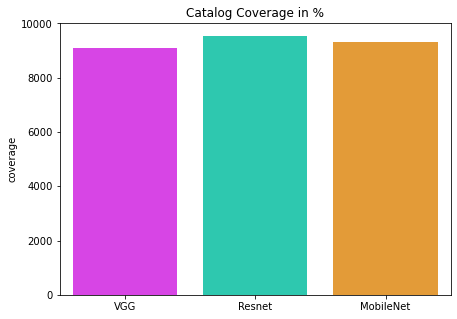

In [69]:
# plot of prediction coverage
coverage_scores = [resnet_coverage, vgg_coverage, mobile_coverage]
model_names = ['VGG', 'Resnet',  'MobileNet']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

In [75]:
df_embs_resnet = pickle.load( open( "embeddings.csv", "rb" ) )

In [76]:
cosine_sim_resnet = 1-pairwise_distances(df_embs_resnet, metric='cosine')

In [77]:
df=pickle.load( open( "./df_preprocess.csv", "rb" ) )

##  9. Displaying some predictions 

In [78]:
# Reference: https://www.kaggle.com/code/mrmaheshchavan/feature-extraction-pca-clustering

indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim_resnet[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(500, df, top_n = 5)

(Int64Index([42577, 32383, 6611, 41474, 40204], dtype='int64'),
 [0.9045471, 0.89757264, 0.8885536, 0.8876667, 0.88646716])

In [79]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

def img_path(img):
    return "data/images/"+img

def load_image(img):
    return cv2.imread(img_path(img))

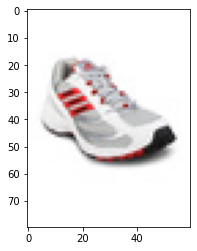

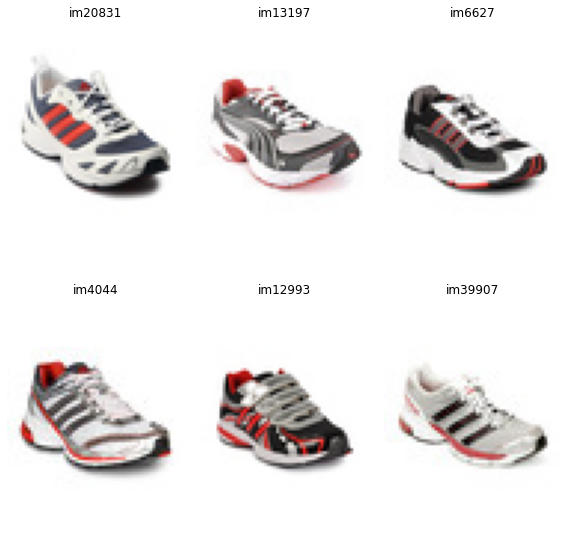

In [129]:
# Idx Item to Recommender
idx_ref = 2500

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(row.id): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

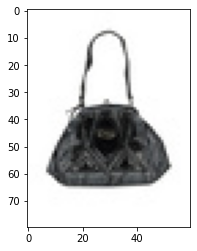

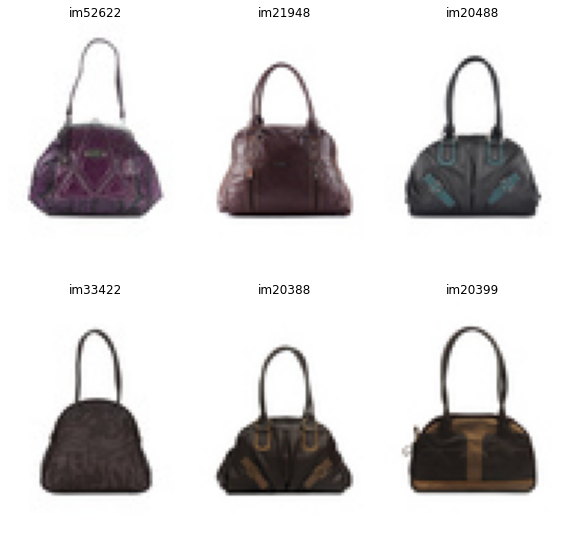

In [118]:
idx_ref = 5300

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(row.id): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

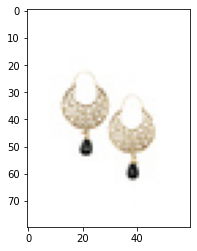

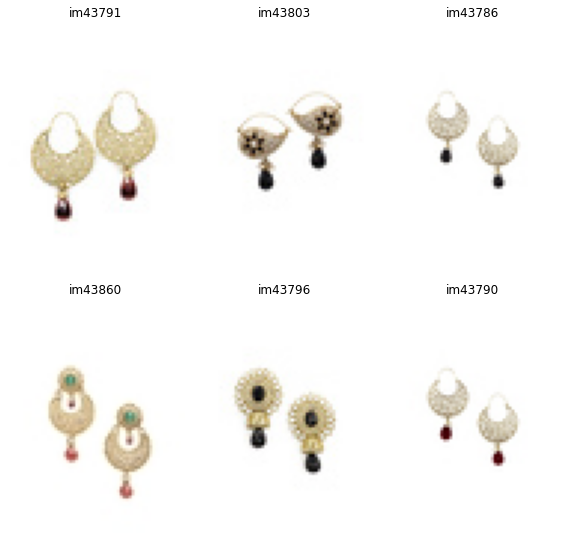

In [117]:
idx_ref = 2000

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(row.id): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)